# 1. IMPORT DEPENDENCIES

In [18]:
# Core Imports for dependencies.
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2  # Pre-trained image model
from tensorflow.keras.layers import Dense  # Output layer
from tensorflow.keras.callbacks import ModelCheckpoint  # Save best model
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Image data handling
import matplotlib.pyplot as plt  # Visualization
import pathlib  # File path operations
import numpy as np

# 2. INITIAL SETUP AND DATA INFO

In [19]:
batch_size = 16  # Images processed per batch
IMAGE_SHAPE = (224, 224, 3)  # MobileNetV2 required input dimensions

In [20]:
# Get dataset path and count images
data_dir = pathlib.Path("dataset")
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Number of images:", image_count)

Number of images: 495


In [21]:
# Get class names from directory structure
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*')])

# 3. PREPARE DATA GENERATORS

In [22]:
# Create image generators with 80-20 train-validation split
image_generator = ImageDataGenerator(
    rescale=1/255,  # Normalize pixel values to [0,1]
    validation_split=0.2  # 20% validation split
)

In [23]:
# Training data generator
trainDataset = image_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size=batch_size,
    classes=list(CLASS_NAMES),
    target_size=IMAGE_SHAPE[:2],  # Resize images
    shuffle=True,
    subset="training"
)

Found 399 images belonging to 10 classes.


In [24]:
# Validation data generator
testDataset = image_generator.flow_from_directory(
    directory=str(data_dir),
    batch_size=batch_size,
    classes=list(CLASS_NAMES),
    target_size=IMAGE_SHAPE[:2],
    shuffle=True,
    subset="validation"
)

Found 96 images belonging to 10 classes.


# 4. MODEL INITIALIZATION

In [25]:
# Load MobileNetV2 with ImageNet weights
model = MobileNetV2(input_shape=IMAGE_SHAPE)
model.summary()  # Show initial architecture



14536120/14536120 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu 

                                                                     'block_2_project_BN[0][0]']  
                                                                                                  
 block_3_expand (Conv2D)     (None, 56, 56, 144)          3456      ['block_2_add[0][0]']         
                                                                                                  
 block_3_expand_BN (BatchNo  (None, 56, 56, 144)          576       ['block_3_expand[0][0]']      
 rmalization)                                                                                     
                                                                                                  
 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )        

                                                                                                  
 block_6_pad (ZeroPadding2D  (None, 29, 29, 192)          0         ['block_6_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_6_depthwise (Depthwi  (None, 14, 14, 192)          1728      ['block_6_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_d

 LU)                                                                                              
                                                                                                  
 block_9_project (Conv2D)    (None, 14, 14, 64)           24576     ['block_9_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_9_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_9_project[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
          

 block_12_add (Add)          (None, 14, 14, 96)           0         ['block_11_add[0][0]',        
                                                                     'block_12_project_BN[0][0]'] 
                                                                                                  
 block_13_expand (Conv2D)    (None, 14, 14, 576)          55296     ['block_12_add[0][0]']        
                                                                                                  
 block_13_expand_BN (BatchN  (None, 14, 14, 576)          2304      ['block_13_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
          

 block_16_expand_BN (BatchN  (None, 7, 7, 960)            3840      ['block_16_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_16_expand_relu (ReLU  (None, 7, 7, 960)            0         ['block_16_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_16_depthwise (Depthw  (None, 7, 7, 960)            8640      ['block_16_expand_relu[0][0]']
 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormali

# 5. MODEL MODIFICATION

In [26]:
# Remove original classification head (1000 classes)
model.layers.pop()

In [30]:
# Freeze all layers except last 4 for transfer learning
for layer in model.layers[:-4]:
    layer.trainable = False

In [32]:
#Add new 10-class classification head
output = Dense(10, activation="softmax")  # 10 output classes
output = output(model.layers[-1].output)  # Connect to model

In [33]:
# Create new model with modified output
model = Model(inputs=model.inputs, outputs=output)
model.summary()  # Show modified architecture

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

 block_3_expand_relu (ReLU)  (None, 56, 56, 144)          0         ['block_3_expand_BN[0][0]']   
                                                                                                  
 block_3_pad (ZeroPadding2D  (None, 57, 57, 144)          0         ['block_3_expand_relu[0][0]'] 
 )                                                                                                
                                                                                                  
 block_3_depthwise (Depthwi  (None, 28, 28, 144)          1296      ['block_3_pad[0][0]']         
 seConv2D)                                                                                        
                                                                                                  
 block_3_depthwise_BN (Batc  (None, 28, 28, 144)          576       ['block_3_depthwise[0][0]']   
 hNormalization)                                                                                  
          

 block_6_depthwise_BN (Batc  (None, 14, 14, 192)          768       ['block_6_depthwise[0][0]']   
 hNormalization)                                                                                  
                                                                                                  
 block_6_depthwise_relu (Re  (None, 14, 14, 192)          0         ['block_6_depthwise_BN[0][0]']
 LU)                                                                                              
                                                                                                  
 block_6_project (Conv2D)    (None, 14, 14, 64)           12288     ['block_6_depthwise_relu[0][0]
                                                                    ']                            
                                                                                                  
 block_6_project_BN (BatchN  (None, 14, 14, 64)           256       ['block_6_project[0][0]']     
 ormalizat

                                                                                                  
 block_9_add (Add)           (None, 14, 14, 64)           0         ['block_8_add[0][0]',         
                                                                     'block_9_project_BN[0][0]']  
                                                                                                  
 block_10_expand (Conv2D)    (None, 14, 14, 384)          24576     ['block_9_add[0][0]']         
                                                                                                  
 block_10_expand_BN (BatchN  (None, 14, 14, 384)          1536      ['block_10_expand[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block_10_expand_relu (ReLU  (None, 14, 14, 384)          0         ['block_10_expand_BN[0][0]']  
 )        

                                                                                                  
 block_13_expand_relu (ReLU  (None, 14, 14, 576)          0         ['block_13_expand_BN[0][0]']  
 )                                                                                                
                                                                                                  
 block_13_pad (ZeroPadding2  (None, 15, 15, 576)          0         ['block_13_expand_relu[0][0]']
 D)                                                                                               
                                                                                                  
 block_13_depthwise (Depthw  (None, 7, 7, 576)            5184      ['block_13_pad[0][0]']        
 iseConv2D)                                                                                       
                                                                                                  
 block_13_

 iseConv2D)                                                                                       
                                                                                                  
 block_16_depthwise_BN (Bat  (None, 7, 7, 960)            3840      ['block_16_depthwise[0][0]']  
 chNormalization)                                                                                 
                                                                                                  
 block_16_depthwise_relu (R  (None, 7, 7, 960)            0         ['block_16_depthwise_BN[0][0]'
 eLU)                                                               ]                             
                                                                                                  
 block_16_project (Conv2D)   (None, 7, 7, 320)            307200    ['block_16_depthwise_relu[0][0
                                                                    ]']                           
          

 # 5. MODEL COMPILATION

In [34]:
model.compile(
    loss="categorical_crossentropy",  # Appropriate for multi-class classification
    optimizer="adam",  # Adaptive learning rate optimizer
    metrics=["acc"]  # Track accuracy metric
)

# 6. TRAINING SETUP WITH MODEL CHECKPOINTING

In [35]:
checkpoint = ModelCheckpoint(
    "model_mobilenet.h5b",
    save_best_only=True,  # Only save better models
    verbose=1  # Show saving notifications
)

In [36]:
# Calculate steps per epoch (required for generator)
trainingStepsPerEpoch = np.ceil(trainDataset.samples / batch_size)
validationStepsPerEpoch = np.ceil(testDataset.samples / batch_size)

# 7. MODEL TRAINING

In [37]:
history = model.fit(
    trainDataset,
    steps_per_epoch=trainingStepsPerEpoch,
    validation_data=testDataset,
    validation_steps=validationStepsPerEpoch,
    epochs=10,
    verbose=1,
    callbacks=[checkpoint]
)

Epoch 1/10


25/25 [==============================] - ETA: 0s - loss: 2.2797 - acc: 0.3058
Epoch 1: val_loss improved from inf to 2.25520, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 18s 620ms/step - loss: 2.2797 - acc: 0.3058 - val_loss: 2.2552 - val_acc: 0.4688
Epoch 2/10
25/25 [==============================] - ETA: 0s - loss: 2.2273 - acc: 0.6942
Epoch 2: val_loss improved from 2.25520 to 2.20027, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 14s 581ms/step - loss: 2.2273 - acc: 0.6942 - val_loss: 2.2003 - val_acc: 0.7708
Epoch 3/10
25/25 [==============================] - ETA: 0s - loss: 2.1721 - acc: 0.7945
Epoch 3: val_loss improved from 2.20027 to 2.14313, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 14s 579ms/step - loss: 2.1721 - acc: 0.7945 - val_loss: 2.1431 - val_acc: 0.8333
Epoch 4/10
25/25 [==============================] - ETA: 0s - loss: 2.1174 - acc: 0.8471
Epoch 4: val_loss improved from 2.14313 to 2.08754, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 14s 583ms/step - loss: 2.1174 - acc: 0.8471 - val_loss: 2.0875 - val_acc: 0.8854
Epoch 5/10
25/25 [==============================] - ETA: 0s - loss: 2.0614 - acc: 0.9123
Epoch 5: val_loss improved from 2.08754 to 2.03643, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 14s 580ms/step - loss: 2.0614 - acc: 0.9123 - val_loss: 2.0364 - val_acc: 0.9375
Epoch 6/10
25/25 [==============================] - ETA: 0s - loss: 2.0074 - acc: 0.9649
Epoch 6: val_loss improved from 2.03643 to 1.98831, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 14s 581ms/step - loss: 2.0074 - acc: 0.9649 - val_loss: 1.9883 - val_acc: 0.9271
Epoch 7/10
25/25 [==============================] - ETA: 0s - loss: 1.9553 - acc: 0.9825
Epoch 7: val_loss improved from 1.98831 to 1.93627, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 14s 584ms/step - loss: 1.9553 - acc: 0.9825 - val_loss: 1.9363 - val_acc: 0.9688
Epoch 8/10
25/25 [==============================] - ETA: 0s - loss: 1.9022 - acc: 0.9900
Epoch 8: val_loss improved from 1.93627 to 1.88701, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 14s 583ms/step - loss: 1.9022 - acc: 0.9900 - val_loss: 1.8870 - val_acc: 0.9688
Epoch 9/10
25/25 [==============================] - ETA: 0s - loss: 1.8522 - acc: 0.9950
Epoch 9: val_loss improved from 1.88701 to 1.84551, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 14s 581ms/step - loss: 1.8522 - acc: 0.9950 - val_loss: 1.8455 - val_acc: 0.9583
Epoch 10/10
25/25 [==============================] - ETA: 0s - loss: 1.8047 - acc: 0.9975
Epoch 10: val_loss improved from 1.84551 to 1.79878, saving model to model_mobilenet.h5b
INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


INFO:tensorflow:Assets written to: model_mobilenet.h5b\assets


25/25 [==============================] - 14s 582ms/step - loss: 1.8047 - acc: 0.9975 - val_loss: 1.7988 - val_acc: 0.9792


# 8. MODEL EVALUATION

In [38]:
model.load_weights("model_mobilenet.h5b")  # Load best saved weights
evaluation = model.evaluate(testDataset)
print(f"Validation Loss: {evaluation[0]:.4f}")
print(f"Validation Accuracy: {evaluation[1]*100:.2f}%")

6/6 [==============================] - 1s 218ms/step - loss: 1.7988 - acc: 0.9792
Validation Loss: 1.7988
Validation Accuracy: 97.92%


# 9. VISUALIZATION OF TRAINING METRICS

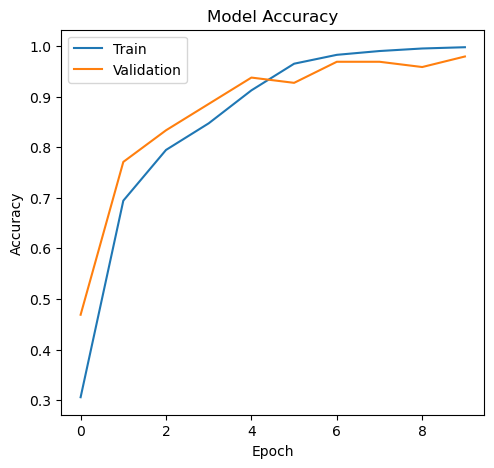

In [39]:
# Plot accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Train')
plt.plot(history.history['val_acc'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

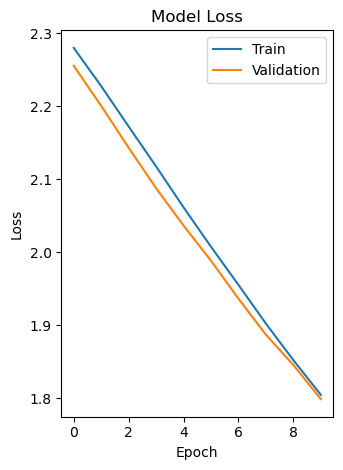

In [40]:
# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()